# 8) 메시지 삭제

그래프의 일반적인 상태 중 하나는 메시지 목록입니다. 일반적으로 해당 상태에 메시지를 추가만 합니다. 하지만 때로는 **메시지를 제거** 해야 할 수도 있습니다. 

이를 위해 `RemoveMessage` 수정자를 사용할 수 있습니다. 그리고, `RemoveMessage` 수정자는 `reducer` 키를 가진다는 것입니다. 

기본 `MessagesState`는 messages 키를 가지고 있으며, 해당 키의 reducer는 이러한 `RemoveMessage` 수정자를 허용합니다.

이 reducer는 `RemoveMessage`를 사용하여 키에서 메시지를 삭제합니다.

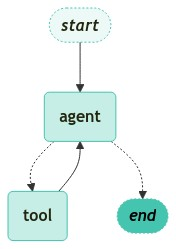

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph

# API 키 정보 로드
load_dotenv()

# 기본적인 graph 구조---------------
memory = MemorySaver()

# 웹 검색 기능을 모방하는 도구 함수 정의
@tool
def search(query: str):
    """Call to surf on the web."""
    return "웹 검색 결과: LangGraph 한글 튜토리얼은 https://wikidocs.net/233785 에서 확인할 수 있습니다."

tools = [search]
tool_node = ToolNode(tools)

model = ChatOpenAI(model_name = "gpt-4o-mini")
bound_model = model.bind_tools(tools)

# 대화 상태에 따른 다음 실행 노드 결정 함수
def should_continue(state:MessagesState):
    last_messages = state['messages'][-1]
    if not last_messages.tool_calls:
        return END
    return "tool"

# LLM 모델 호출 및 응답 처리 함수
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# 시작점을 에이전트 노드로 설정
workflow.add_edge(START, "agent")

# 조건부 엣지 설정: 에이전트 노드 이후의 실행 흐름 정의
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# 도구 실행 후 에이전트로 돌아가는 엣지 추가
workflow.add_edge("tool", "agent")

# 체크포인터가 포함된 최종 실행 가능한 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

visualize_graph(app)


In [2]:
# 첫 질문
from langchain_core.messages import HumanMessage

# 스레드 ID가 1인 기본 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)

# 스트림 모드로 메시지 처리 및 응답 출력, 마지막 메시지의 상세 정보 표시
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [3]:
# 후속 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

# 스트림 모드로 두 번째 메시지 처리 및 응답 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


In [4]:
# 단계별 상태 확인
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


### RemoveMessage 수정자를 사용하여 메시지 삭제

먼저 메시지를 수동으로 삭제하는 방법을 살펴보겠습니다. 현재 스레드의 상태를 확인해보겠습니다:

In [5]:
from langchain_core.messages import RemoveMessage

# 메시지 배열의 첫 번째 메시지를 ID 기반으로 제거하고 앱 상태 업데이트
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

# 이제 메시지들을 확인해보면 첫 번째 메시지가 삭제되었음을 확인할 수 있습니다.
# 앱 상태에서 메시지 목록 추출 및 저장된 대화 내역 조회
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Remove Message ================================


================================== Ai Message ==================================

안녕하세요, Teddy! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다. 맞나요?


C:\Users\user\AppData\Local\Temp\ipykernel_22740\1008945876.py:4: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})


### 더 많은 메시지를 동적으로 삭제

그래프 내부에서 프로그래밍 방식으로 메시지를 삭제할 수도 있습니다. 

그래프 실행이 종료될 때 오래된 메시지(3개 이전의 메시지보다 더 이전의 메시지)를 삭제하도록 그래프를 수정하는 방법을 살펴보겠습니다.

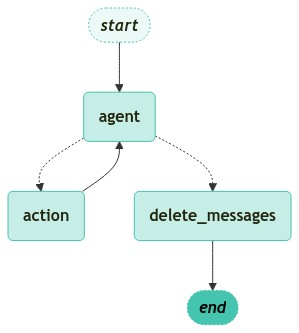

In [6]:
# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 액션 실행
    return "action"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 메시지 삭제 노드 추가
workflow.add_node(delete_messages)

# 시작 노드에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 조건부 엣지 추가를 통한 노드 간 흐름 제어
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 액션 노드에서 에이전트 노드로 연결
workflow.add_edge("action", "agent")

# 메시지 삭제 노드에서 종료 노드로 연결
workflow.add_edge("delete_messages", END)

# 메모리 체크포인터를 사용하여 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

visualize_graph(app)


In [7]:
# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "2"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?')]


In [8]:
# 2번째 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이시죠! 맞나요?')]
[('remove', ''), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이시죠! 맞나요?')]


In [9]:
# 최종 상태를 확인해보면 메시지가 단 세 개만 있는 것을 확인할 수 있습니다. 

# 이는 이전 메시지들을 방금 삭제했기 때문입니다.

# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()

================================ Remove Message ================================


================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Teddy님이시죠! 맞나요?


# 9) ToolNode 를 사용하여 도구를 호출하는 방법

이번 튜토리얼에서는 도구 호출을 위한 LangGraph의 사전 구축된 `pre-built`의 `ToolNode` 사용 방법을 다룹니다.

`ToolNode`는 메시지 목록이 포함된 그래프 상태를 입력으로 받아 도구 호출 결과로 상태를 업데이트하는 LangChain Runnable입니다. 

이는 LangGraph의 사전 구축된 Agent 와 즉시 사용할 수 있도록 설계되었으며, 상태에 적절한 리듀서가 있는 `messages` 키가 포함된 경우 모든 `StateGraph` 와 함께 작동할 수 있습니다.

In [10]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [11]:
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_teddynote.tools import GoogleNews
from typing import List, Dict
from langgraph.prebuilt import ToolNode, tools_condition

# 도구 정의

# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

# 다음으로는 `ToolNode` 를 사용하여 도구를 호출하는 방법을 살펴보겠습니다.
# 도구 리스트 생성
tools = [search_news, python_code_interpreter]

# ToolNode 초기화
tool_node = ToolNode(tools)

c:\Users\user\anaconda3\envs\myenv\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


###  `ToolNode`를 수동으로 호출하기

`ToolNode`는 메시지 목록과 함께 그래프 상태에서 작동합니다. 

- **중요**: 이때 목록의 마지막 메시지는 `tool_calls` 속성을 포함하는 `AIMessage`여야 합니다.

먼저 도구 노드를 수동으로 호출하는 방법을 살펴보겠습니다.

In [12]:
from langchain_core.messages import AIMessage

# 단일 도구 호출을 포함하는 AI 메시지 객체 생성
# AIMessage 객체이어야 함
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",  # 도구 이름 <------이름 명시하여 지정해서 사용 가능
            "args": {"query": "AI"},  # 도구 인자
            "id": "tool_call_id",  # 도구 호출 ID
            "type": "tool_call",  # 도구 호출 유형
        }
    ],
)

# 도구 노드를 통한 메시지 처리 및 날씨 정보 요청 실행
tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\\uc624\\ud508AI, \\uac00\\uc7a5 \\ud070 AI \\ubaa8\\ub378 \'GPT-4.5\' \\uacf5\\uac1c...\\ube44\\ucd94\\ub860 \\ubaa8\\ub378 \\ud55c\\uacc4 \\ubcf4\\uc5ec\\uc918 - AI\\ud0c0\\uc784\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM25lUjV6b2hXcUs3V3NqQjFfWG1xWjlVZ3V1eFFCT2p2eWpwRE1aekpBX2ZJNnBHWHJoVm4yLXl2MnhtVmtTcVc5aGl5MTd6QVM?oc=5", "content": "\\uc624\\ud508AI, \\ucd5c\\uc2e0 AI \\ubaa8\\ub378 GPT-4.5 \\ucd9c\\uc2dc\\u2026\\"\\ub300\\ud654\\ud615 \\ubaa8\\ub378 \\ucd5c\\uac15\\" - \\uc5f0\\ud569\\ub274\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQQ

일반적으로 `AIMessage`를 수동으로 생성할 필요가 없으며, 도구 호출을 지원하는 모든 LangChain 채팅 모델에서 자동으로 생성됩니다.

또한 `AIMessage`의 `tol_callos` 매개변수에 여러 도구 호출을 전달하면 `ToolNode`를 사용하여 병렬 도구 호출을 수행할 수 있습니다.

In [13]:
# 다중 도구 호출을 포함하는 AI 메시지 객체 생성 및 초기화
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "AI"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

# 생성된 메시지를 도구 노드에 전달하여 다중 도구 호출 실행
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\\uc624\\ud508AI, \\uac00\\uc7a5 \\ud070 AI \\ubaa8\\ub378 \'GPT-4.5\' \\uacf5\\uac1c...\\ube44\\ucd94\\ub860 \\ubaa8\\ub378 \\ud55c\\uacc4 \\ubcf4\\uc5ec\\uc918 - AI\\ud0c0\\uc784\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM25lUjV6b2hXcUs3V3NqQjFfWG1xWjlVZ3V1eFFCT2p2eWpwRE1aekpBX2ZJNnBHWHJoVm4yLXl2MnhtVmtTcVc5aGl5MTd6QVM?oc=5", "content": "\\uc624\\ud508AI, \\ucd5c\\uc2e0 AI \\ubaa8\\ub378 GPT-4.5 \\ucd9c\\uc2dc\\u2026\\"\\ub300\\ud654\\ud615 \\ubaa8\\ub378 \\ucd5c\\uac15\\" - \\uc5f0\\ud569\\ub274\\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQQ

### llm 과 함께 사용하기

도구 호출 기능이 있는 채팅 모델을 사용하기 위해서는 먼저 모델이 사용 가능한 도구들을 인식하도록 해야 합니다. 

이는 `ChatOpenAI` 모델에서 `.bind_tools` 메서드를 호출하여 수행합니다.

In [14]:
# LLM 모델 초기화 및 도구 바인딩
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)

In [15]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls

[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for i in range(2, int(num**0.5) + 1):\n            if num % i == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_yDgiERfBzf9ml2LGBA13vFFr',
  'type': 'tool_call'}]

- 보시다시피 채팅 모델이 생성한 AI 메시지에는 이미 `tool_calls`가 채워져 있으므로, 이를 `ToolNode`에 직접 전달할 수 있습니다.
- 위에서 ToolNode를 수동으로 호출하기 위해 tool_calls 넣어준 것과 같음

In [16]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)

{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]', name='python_code_interpreter', tool_call_id='call_BMjg9OdoJsclgobu2J3R4MeT')]}

### Agent 와 함께 사용하기

다음으로, LangGraph 그래프 내에서 `ToolNode`를 사용하는 방법을 살펴보겠습니다. 

Agent 의 그래프 구현을 설정해보겠습니다. 이 **Agent** 는 쿼리를 입력으로 받아, 쿼리를 해결하는 데 필요한 충분한 정보를 얻을 때까지 반복적으로 도구들을 호출합니다. 

방금 정의한 도구들과 함께 `ToolNode` 및 OpenAI 모델을 사용하게 됩니다.

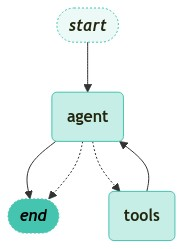

In [17]:
# LangGraph 워크플로우 상태 및 메시지 처리를 위한 타입 임포트
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 메시지 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 워크플로우 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

# 도구 노드에서 에이전트 노드로 순환 연결
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


# 정의된 워크플로우 그래프 컴파일 및 실행 가능한 애플리케이션 생성
app = workflow.compile()

visualize_graph(app)

In [18]:
# 실행 및 결과 확인
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_dRzshEwCjt8VuCbQdb772Mhr)
 Call ID: call_dRzshEwCjt8VuCbQdb772Mhr
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]
================================== Ai Message ==================================

처음 5개의 소수는 다음과 같습니다: [2, 3, 5, 7, 11]


In [19]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "search google news about AI")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

search google news about AI
================================== Ai Message ==================================
Tool Calls:
  search_news (call_HKDIXkzkvxSRh8QlRutDd9xe)
 Call ID: call_HKDIXkzkvxSRh8QlRutDd9xe
  Args:
    query: AI
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTE5zT3VxSkxjUW1fMEJVU3J6TVhFYkF4QkhZUC1KVHFmeXhNQk9UemVEQi1IVUdrbUV0S2FPdkZYWDVMZmczRnhVcTZzcVlQQk44MTg4emkyTG05d3ZiOTFhdVpyRHJwa2ExY3c?oc=5", "content": "\uc624\ud508AI, \uac00\uc7a5 \ud070 AI \ubaa8\ub378 'GPT-4.5' \uacf5\uac1c...\ube44\ucd94\ub860 \ubaa8\ub378 \ud55c\uacc4 \ubcf4\uc5ec\uc918 - AI\ud0c0\uc784\uc2a4"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE1KSUV3VUUwQThfWTlGMFBqLXJ2RnZxdWFNbmllQTVmVVVwc3ZDZVpvMXkyQVZsUjZjNG44TTJTdElibUpwQlFGZEJjcEhNV2ZtTmdGQ25haXV4OGvSAWBBVV95cUxQeTFzVC1kTkxuc1JHOUtLM2

In [20]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 반가워요. 어떻게 도와드릴까요?


- `ToolNode`는 도구 실행 중 발생하는 오류도 처리할 수 있습니다. 

- `handle_tool_errors=True`를 설정하여 이 기능을 활성화/비활성화할 수 있습니다(기본적으로 활성화되어 있음)